In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

In [2]:
batch_size = 8
learning_rate = 0.002
num_epochs = 800

In [3]:
normal_dir = 'C:\\Users\\WorkStation\\Desktop\\CAE_dataset\\normal'
abnormal_dir = 'C:\\Users\\WorkStation\\Desktop\\CAE_dataset\\abnormal3'

normal_set = datasets.ImageFolder(
    normal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

abnormal_set = datasets.ImageFolder(
    abnormal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

train_set, test_set = torch.utils.data.random_split(normal_set, [len(normal_set) - 50, 50])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True)
normal_loader = torch.utils.data.DataLoader(normal_set, batch_size=batch_size, shuffle=True)
abnormal_loader = torch.utils.data.DataLoader(abnormal_set, batch_size=batch_size,shuffle=True)
print(len(normal_loader))

38


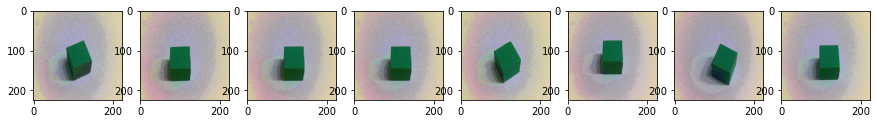

In [4]:
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(batch_size), images, labels):
    numpy_img = np.transpose(img.numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, batch_size, i+1)
    ax.imshow(numpy_img)
plt.show()

**AutoEncoder**

In [5]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                         nn.MaxPool2d(2,2))

        self.cnn_layer2 = nn.Sequential(
                                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                 nn.MaxPool2d(2,2))
        
        self.cnn_layer3 = nn.Sequential(
                                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                 nn.MaxPool2d(2,2))

        # Decoder        
        self.tran_cnn_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding=0),
                        nn.ReLU())
        
        self.tran_cnn_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                        nn.ReLU())

        self.tran_cnn_layer3 = nn.Sequential(
                        nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
                        nn.Sigmoid())
            
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)
        output = self.cnn_layer3(output)        
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)
        output = self.tran_cnn_layer3(output)

        return output
ConvAutoEncoder()

ConvAutoEncoder(
  (cnn_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran_cnn_layer1): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer2): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer3): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  

In [7]:
model = ConvAutoEncoder()
model.load_state_dict(torch.load('best_model_final.pth'))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**train**

In [8]:
steps = 0
#total_steps = len(train_loader)
BEST_MODEL_PATH = 'best_model_final.pth'
best_loss = 1.0
best_accuracy = 0.0

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    ########### Training ###########
    steps = 0
    train_loss = 0
    for i, (X_train, _) in enumerate(train_loader):
        steps += 1

        outputs = model(X_train)
        loss = criterion(outputs, X_train)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
    ########### Test ###########
    model.eval()
    steps = 0
    test_loss = 0
    for i, (X_test, _) in enumerate(test_loader):
        steps += 1
    
        outputs = model(X_test)
        
        loss = criterion(outputs, X_test)
        test_loss += loss.item()
        
        ##### Accuracy #####
        
        
    print('Epoch: {}/{}'.format(epoch+1, num_epochs),
          'Train loss: {:.5f}..'.format(train_loss/len(train_loader)), 
          'Test loss: {:.5f}..'.format(test_loss/len(test_loader)))
    
    train_losses.append(train_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))
      
    ########### save model ###########    
    if test_loss < best_loss:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_loss = test_loss
    
    model.train()

Epoch: 1/800 Train loss: 0.03485.. Test loss: 0.01827..
Epoch: 2/800 Train loss: 0.01372.. Test loss: 0.00916..
Epoch: 3/800 Train loss: 0.00561.. Test loss: 0.00410..
Epoch: 4/800 Train loss: 0.00368.. Test loss: 0.00333..
Epoch: 5/800 Train loss: 0.00321.. Test loss: 0.00295..
Epoch: 6/800 Train loss: 0.00289.. Test loss: 0.00271..
Epoch: 7/800 Train loss: 0.00267.. Test loss: 0.00252..
Epoch: 8/800 Train loss: 0.00250.. Test loss: 0.00232..
Epoch: 9/800 Train loss: 0.00229.. Test loss: 0.00216..
Epoch: 10/800 Train loss: 0.00217.. Test loss: 0.00204..
Epoch: 11/800 Train loss: 0.00203.. Test loss: 0.00209..
Epoch: 12/800 Train loss: 0.00199.. Test loss: 0.00190..
Epoch: 13/800 Train loss: 0.00193.. Test loss: 0.00189..
Epoch: 14/800 Train loss: 0.00185.. Test loss: 0.00182..
Epoch: 15/800 Train loss: 0.00184.. Test loss: 0.00178..
Epoch: 16/800 Train loss: 0.00177.. Test loss: 0.00174..
Epoch: 17/800 Train loss: 0.00177.. Test loss: 0.00178..
Epoch: 18/800 Train loss: 0.00172.. Test

Epoch: 145/800 Train loss: 0.00103.. Test loss: 0.00100..
Epoch: 146/800 Train loss: 0.00102.. Test loss: 0.00103..
Epoch: 147/800 Train loss: 0.00102.. Test loss: 0.00114..
Epoch: 148/800 Train loss: 0.00104.. Test loss: 0.00101..
Epoch: 149/800 Train loss: 0.00102.. Test loss: 0.00101..
Epoch: 150/800 Train loss: 0.00103.. Test loss: 0.00099..
Epoch: 151/800 Train loss: 0.00102.. Test loss: 0.00101..
Epoch: 152/800 Train loss: 0.00105.. Test loss: 0.00103..
Epoch: 153/800 Train loss: 0.00103.. Test loss: 0.00100..
Epoch: 154/800 Train loss: 0.00101.. Test loss: 0.00100..
Epoch: 155/800 Train loss: 0.00101.. Test loss: 0.00105..
Epoch: 156/800 Train loss: 0.00102.. Test loss: 0.00099..
Epoch: 157/800 Train loss: 0.00102.. Test loss: 0.00102..
Epoch: 158/800 Train loss: 0.00102.. Test loss: 0.00098..
Epoch: 159/800 Train loss: 0.00103.. Test loss: 0.00099..
Epoch: 160/800 Train loss: 0.00102.. Test loss: 0.00100..
Epoch: 161/800 Train loss: 0.00102.. Test loss: 0.00100..
Epoch: 162/800

Epoch: 287/800 Train loss: 0.00095.. Test loss: 0.00095..
Epoch: 288/800 Train loss: 0.00096.. Test loss: 0.00101..
Epoch: 289/800 Train loss: 0.00097.. Test loss: 0.00095..
Epoch: 290/800 Train loss: 0.00095.. Test loss: 0.00092..
Epoch: 291/800 Train loss: 0.00095.. Test loss: 0.00093..
Epoch: 292/800 Train loss: 0.00096.. Test loss: 0.00093..
Epoch: 293/800 Train loss: 0.00095.. Test loss: 0.00094..
Epoch: 294/800 Train loss: 0.00096.. Test loss: 0.00105..
Epoch: 295/800 Train loss: 0.00096.. Test loss: 0.00094..
Epoch: 296/800 Train loss: 0.00095.. Test loss: 0.00093..
Epoch: 297/800 Train loss: 0.00096.. Test loss: 0.00093..
Epoch: 298/800 Train loss: 0.00095.. Test loss: 0.00094..
Epoch: 299/800 Train loss: 0.00096.. Test loss: 0.00098..
Epoch: 300/800 Train loss: 0.00096.. Test loss: 0.00093..
Epoch: 301/800 Train loss: 0.00095.. Test loss: 0.00095..
Epoch: 302/800 Train loss: 0.00096.. Test loss: 0.00097..
Epoch: 303/800 Train loss: 0.00096.. Test loss: 0.00093..
Epoch: 304/800

Epoch: 429/800 Train loss: 0.00093.. Test loss: 0.00090..
Epoch: 430/800 Train loss: 0.00092.. Test loss: 0.00091..
Epoch: 431/800 Train loss: 0.00092.. Test loss: 0.00090..
Epoch: 432/800 Train loss: 0.00092.. Test loss: 0.00089..
Epoch: 433/800 Train loss: 0.00095.. Test loss: 0.00092..
Epoch: 434/800 Train loss: 0.00093.. Test loss: 0.00089..
Epoch: 435/800 Train loss: 0.00092.. Test loss: 0.00089..
Epoch: 436/800 Train loss: 0.00092.. Test loss: 0.00092..
Epoch: 437/800 Train loss: 0.00094.. Test loss: 0.00090..
Epoch: 438/800 Train loss: 0.00092.. Test loss: 0.00090..
Epoch: 439/800 Train loss: 0.00093.. Test loss: 0.00090..
Epoch: 440/800 Train loss: 0.00092.. Test loss: 0.00089..
Epoch: 441/800 Train loss: 0.00093.. Test loss: 0.00092..
Epoch: 442/800 Train loss: 0.00092.. Test loss: 0.00091..
Epoch: 443/800 Train loss: 0.00093.. Test loss: 0.00091..
Epoch: 444/800 Train loss: 0.00093.. Test loss: 0.00089..
Epoch: 445/800 Train loss: 0.00092.. Test loss: 0.00090..
Epoch: 446/800

Epoch: 571/800 Train loss: 0.00088.. Test loss: 0.00086..
Epoch: 572/800 Train loss: 0.00088.. Test loss: 0.00086..
Epoch: 573/800 Train loss: 0.00088.. Test loss: 0.00087..
Epoch: 574/800 Train loss: 0.00088.. Test loss: 0.00088..
Epoch: 575/800 Train loss: 0.00088.. Test loss: 0.00085..
Epoch: 576/800 Train loss: 0.00088.. Test loss: 0.00086..
Epoch: 577/800 Train loss: 0.00087.. Test loss: 0.00086..
Epoch: 578/800 Train loss: 0.00088.. Test loss: 0.00087..
Epoch: 579/800 Train loss: 0.00087.. Test loss: 0.00085..
Epoch: 580/800 Train loss: 0.00089.. Test loss: 0.00089..
Epoch: 581/800 Train loss: 0.00088.. Test loss: 0.00086..
Epoch: 582/800 Train loss: 0.00087.. Test loss: 0.00087..
Epoch: 583/800 Train loss: 0.00088.. Test loss: 0.00085..
Epoch: 584/800 Train loss: 0.00089.. Test loss: 0.00087..
Epoch: 585/800 Train loss: 0.00087.. Test loss: 0.00086..
Epoch: 586/800 Train loss: 0.00087.. Test loss: 0.00086..
Epoch: 587/800 Train loss: 0.00087.. Test loss: 0.00085..
Epoch: 588/800

Epoch: 713/800 Train loss: 0.00085.. Test loss: 0.00083..
Epoch: 714/800 Train loss: 0.00085.. Test loss: 0.00085..
Epoch: 715/800 Train loss: 0.00085.. Test loss: 0.00084..
Epoch: 716/800 Train loss: 0.00085.. Test loss: 0.00082..
Epoch: 717/800 Train loss: 0.00084.. Test loss: 0.00083..
Epoch: 718/800 Train loss: 0.00085.. Test loss: 0.00083..
Epoch: 719/800 Train loss: 0.00084.. Test loss: 0.00083..
Epoch: 720/800 Train loss: 0.00086.. Test loss: 0.00083..
Epoch: 721/800 Train loss: 0.00084.. Test loss: 0.00084..
Epoch: 722/800 Train loss: 0.00085.. Test loss: 0.00084..
Epoch: 723/800 Train loss: 0.00085.. Test loss: 0.00084..
Epoch: 724/800 Train loss: 0.00085.. Test loss: 0.00083..
Epoch: 725/800 Train loss: 0.00085.. Test loss: 0.00082..
Epoch: 726/800 Train loss: 0.00084.. Test loss: 0.00090..
Epoch: 727/800 Train loss: 0.00085.. Test loss: 0.00083..
Epoch: 728/800 Train loss: 0.00086.. Test loss: 0.00083..
Epoch: 729/800 Train loss: 0.00084.. Test loss: 0.00083..
Epoch: 730/800

In [9]:
model.eval()

normal_loss = 0
normal_losses = []

abnormal_loss = 0
abnormal_losses = []

for i, (normal_img, _) in enumerate(normal_loader):
    normal_outputs = model(normal_img)
        
    loss = criterion(normal_outputs, normal_img)
    normal_loss = loss.item()
    normal_losses.append(normal_loss)
    
    print('normal loss: {:.5f}..'.format(normal_loss))
    

for i, (abnormal_img, _) in enumerate(abnormal_loader):   
    abnormal_outputs = model(abnormal_img)
        
    loss = criterion(abnormal_outputs,abnormal_img)
    abnormal_loss = loss.item()
    abnormal_losses.append(abnormal_loss)
    
    print('Abnormal loss: {:.5f}..'.format(abnormal_loss))

normal loss: 0.00077..
normal loss: 0.00088..
normal loss: 0.00087..
normal loss: 0.00082..
normal loss: 0.00086..
normal loss: 0.00082..
normal loss: 0.00086..
normal loss: 0.00083..
normal loss: 0.00086..
normal loss: 0.00082..
normal loss: 0.00082..
normal loss: 0.00085..
normal loss: 0.00088..
normal loss: 0.00083..
normal loss: 0.00085..
normal loss: 0.00088..
normal loss: 0.00087..
normal loss: 0.00085..
normal loss: 0.00086..
normal loss: 0.00080..
normal loss: 0.00083..
normal loss: 0.00086..
normal loss: 0.00090..
normal loss: 0.00087..
normal loss: 0.00083..
normal loss: 0.00083..
normal loss: 0.00083..
normal loss: 0.00089..
normal loss: 0.00083..
normal loss: 0.00083..
normal loss: 0.00084..
normal loss: 0.00085..
normal loss: 0.00085..
normal loss: 0.00084..
normal loss: 0.00087..
normal loss: 0.00086..
normal loss: 0.00086..
normal loss: 0.00085..
Abnormal loss: 0.00139..
Abnormal loss: 0.00124..
Abnormal loss: 0.00128..
Abnormal loss: 0.00125..
Abnormal loss: 0.00121..
A

Abnormal loss: 0.00125..
Abnormal loss: 0.00144..
Abnormal loss: 0.00178..
Abnormal loss: 0.00129..
Abnormal loss: 0.00122..
Abnormal loss: 0.00125..
Abnormal loss: 0.00175..
Abnormal loss: 0.00121..
Abnormal loss: 0.00128..
Abnormal loss: 0.00123..
Abnormal loss: 0.00178..
Abnormal loss: 0.00125..
Abnormal loss: 0.00176..
Abnormal loss: 0.00121..
Abnormal loss: 0.00177..
Abnormal loss: 0.00121..
Abnormal loss: 0.00121..
Abnormal loss: 0.00121..
Abnormal loss: 0.00124..
Abnormal loss: 0.00122..
Abnormal loss: 0.00143..
Abnormal loss: 0.00123..
Abnormal loss: 0.00128..
Abnormal loss: 0.00124..
Abnormal loss: 0.00121..
Abnormal loss: 0.00123..
Abnormal loss: 0.00182..
Abnormal loss: 0.00118..
Abnormal loss: 0.00125..
Abnormal loss: 0.00128..
Abnormal loss: 0.00138..
Abnormal loss: 0.00163..
Abnormal loss: 0.00125..
Abnormal loss: 0.00125..
Abnormal loss: 0.00180..
Abnormal loss: 0.00139..
Abnormal loss: 0.00122..
Abnormal loss: 0.00126..
Abnormal loss: 0.00124..
Abnormal loss: 0.00126..


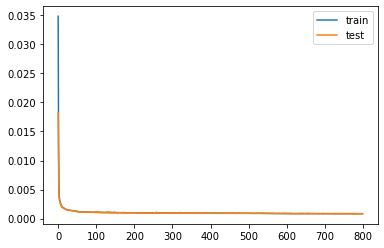

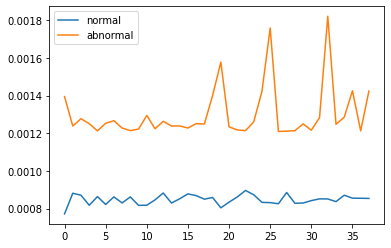

In [18]:
plt.figure(1)
plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(normal_losses, label = 'normal')
plt.plot(abnormal_losses[:38], label = 'abnormal')
plt.legend()
plt.show()

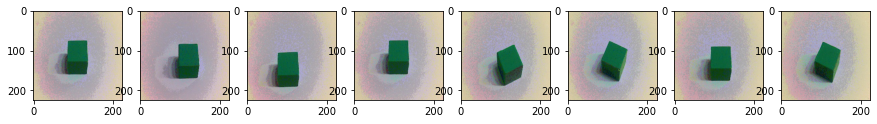

In [8]:
abnormal_images, abnormal_labels = next(iter(normal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(batch_size), abnormal_images, abnormal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, batch_size, i+1)
    ax.imshow(numpy_img)
plt.show()

C:\Users\WorkStation\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([8, 3, 224, 224])) that is different to the input size (torch.Size([3, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.009847129695117474
0.009187057614326477
0.014444414526224136
0.009893556125462055
0.009684146381914616
0.006946930196136236
0.008097633719444275
0.00707551883533597


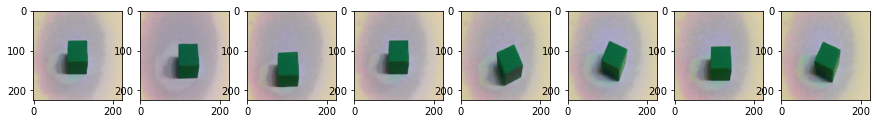

In [9]:
abnormal_output = model(abnormal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(batch_size), abnormal_output, abnormal_labels):
    loss = criterion(img, abnormal_images)
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, batch_size, i+1)
    ax.imshow(numpy_img)
plt.show()